In [1]:
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.keras.utils import to_categorical
import random,shutil
from keras.models import Sequential
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization
from keras.models import load_model
import pandas as pd
import cv2
from pathlib import Path

In [2]:
def generator(dir, gen=image.ImageDataGenerator(rescale=1./255), shuffle=True,batch_size=1,target_size=(24,24),class_mode='categorical' ):

    return gen.flow_from_directory(dir,batch_size=batch_size,shuffle=shuffle,color_mode='grayscale',class_mode=class_mode,target_size=target_size)


In [6]:
path =  r"D:\archive (13)\dataset_new"
img_dir = Path(path)
print(img_dir)

D:\archive (13)\dataset_new


In [7]:
# get filePaths and labels
filepaths = list(img_dir.glob(r'**/*.JPG')) + list(img_dir.glob(r'**/*.jpg')) 
labels = list(map( lambda x:os.path.split(os.path.split(x)[0])[1] , filepaths))

# Convert type to Series
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
DF = pd.concat([filepaths, labels], axis=1)  # image_df
print(DF)

                                              Filepath   Label
0     D:\archive (13)\dataset_new\test\Closed\_107.jpg  Closed
1     D:\archive (13)\dataset_new\test\Closed\_115.jpg  Closed
2     D:\archive (13)\dataset_new\test\Closed\_116.jpg  Closed
3     D:\archive (13)\dataset_new\test\Closed\_120.jpg  Closed
4     D:\archive (13)\dataset_new\test\Closed\_129.jpg  Closed
...                                                ...     ...
2899    D:\archive (13)\dataset_new\train\Open\_93.jpg    Open
2900    D:\archive (13)\dataset_new\train\Open\_94.jpg    Open
2901    D:\archive (13)\dataset_new\train\Open\_97.jpg    Open
2902    D:\archive (13)\dataset_new\train\Open\_98.jpg    Open
2903    D:\archive (13)\dataset_new\train\Open\_99.jpg    Open

[2904 rows x 2 columns]


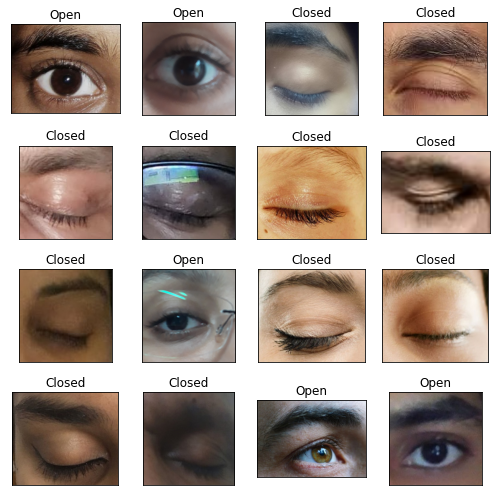

In [8]:
random_index = np.random.randint(0 , len(DF) , 20)
fig,axes = plt.subplots(nrows=4 , ncols=4 , figsize=(7,7) , subplot_kw={'xticks': [], 'yticks': []} )

for i , ax in enumerate(axes.flat):
    ax.imshow(plt.imread(DF.Filepath[random_index[i]]))
    ax.set_title(DF.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [9]:
im = plt.imread(DF.Filepath[6])
im.shape

(300, 376, 3)

In [10]:
DF = DF.sample(frac=1 , random_state=42).reset_index(drop=True)
DF

,Filepath,Label
0,D:\archive (13)\dataset_new\test\Open\_243.jpg,Open
1,D:\archive (13)\dataset_new\train\Closed\_83.jpg,Closed
2,D:\archive (13)\dataset_new\train\Closed\_390.jpg,Closed
3,D:\archive (13)\dataset_new\train\Closed\_15.jpg,Closed
4,D:\archive (13)\dataset_new\train\Open\_487.jpg,Open
...,...,...
2899,D:\archive (13)\dataset_new\test\Open\_559.jpg,Open
2900,D:\archive (13)\dataset_new\train\Open\_382.jpg,Open
2901,D:\archive (13)\dataset_new\train\Open\_415.jpg,Open
2902,D:\archive (13)\dataset_new\train\Open\_587.jpg,Open


In [11]:
test_DF = DF.iloc[len(DF)-600 :  , :]
DF = DF.iloc[:len(DF)-600 , :]

In [12]:
print(len(test_DF))
print(len(DF))

600
2304


In [13]:
test_DF.shape
DF.shape

(2304, 2)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
# BS= 32
# TS=(135,135)
# train_batch= generator('E:/archive (13)/dataset_new/train',shuffle=True, batch_size=BS,target_size=TS)
# valid_batch= generator('E:/archive (13)/dataset_new/test',shuffle=True, batch_size=BS,target_size=TS)
# SPE= len(train_batch.classes)//BS
# VS = len(valid_batch.classes)//BS
# print(SPE,VS)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # set validation split
train_image = train_datagen.flow_from_directory(path, target_size=(132,132) , seed=101 , batch_size=32 , class_mode='categorical' , subset='training')
test_image = train_datagen.flow_from_directory(path, target_size=(132,132) , seed=101 , batch_size=32 , class_mode='categorical' , subset='validation')

Found 1163 images belonging to 2 classes.
Found 289 images belonging to 2 classes.


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers,losses

In [17]:
# model = Sequential([
#     Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(135,135,3)),
#     MaxPooling2D(pool_size=(1,1)),
#     Conv2D(32,(3,3),activation='relu'),
#     MaxPooling2D(pool_size=(1,1)),
# #32 convolution filters used each of size 3x3
# #again
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(1,1)),

# #64 convolution filters used each of size 3x3
# #choose the best features via pooling
    
# #randomly turn neurons on and off to improve convergence
#     Dropo ut(0.25),
# #flatten since too many dimensions, we only want a classification output
#     Flatten(),
# #fully connected to get all relevant data
#     Dense(128, activation='relu'),
# #one more dropout for convergence' sake :) 
#     Dropout(0.5),
# #output a softmax to squash the matrix into output probabilities
#     Dense(2, activation='softmax')
# ])

CNNModel1 = keras.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(132, 132, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(128, activation = 'relu', kernel_regularizer='l1'),
    layers.Dense(2, activation = 'sigmoid')
])

In [18]:
CNNModel1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
model2History = CNNModel1.fit(train_image , steps_per_epoch=len(train_image) , validation_data= test_image , validation_steps=len(test_image) , epochs=10)

Epoch 1/10
37/37 [==============================] - 53s 1s/step - loss: 21.3976 - accuracy: 0.7395 - val_loss: 16.6816 - val_accuracy: 0.4291
Epoch 2/10
37/37 [==============================] - 43s 1s/step - loss: 14.9833 - accuracy: 0.7653 - val_loss: 16.3088 - val_accuracy: 0.1661
Epoch 3/10
37/37 [==============================] - 43s 1s/step - loss: 11.3337 - accuracy: 0.7773 - val_loss: 9.3992 - val_accuracy: 0.8512
Epoch 4/10
37/37 [==============================] - 42s 1s/step - loss: 8.9266 - accuracy: 0.7687 - val_loss: 8.8400 - val_accuracy: 0.8512
Epoch 5/10
37/37 [==============================] - 42s 1s/step - loss: 7.4467 - accuracy: 0.7653 - val_loss: 6.9786 - val_accuracy: 0.8512
Epoch 6/10
37/37 [==============================] - 42s 1s/step - loss: 6.5879 - accuracy: 0.7773 - val_loss: 6.0604 - val_accuracy: 0.8512
Epoch 7/10
37/37 [==============================] - 41s 1s/step - loss: 5.6050 - accuracy: 0.8057 - val_loss: 5.6102 - val_accuracy: 0.8512
Epoch 8/10
37/3

In [20]:
def TestInput(CNNModelSaved , imgMatrix):
    labels=["Closed" , "Open"]
    imgMatrix = cv2.resize(imgMatrix , (132,132))
    imgMatrix = imgMatrix.astype('float32')
    imgMatrix /= 255.0
    imgMatrix = cv2.cvtColor(imgMatrix, cv2.COLOR_BGR2RGB)
    imgMatrix = imgMatrix.reshape((1, 132, 132, 3))
    c = CNNModelSaved.predict(imgMatrix)
    p = np.argmax(c)
    print(c)
    return labels[p]

In [21]:
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 469ms/step
[[0.00107559 0.09390937]]
Open
Open


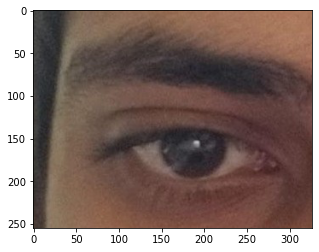

In [22]:
y_act_data = plt.imread(test_DF.Filepath.iloc[6])
y_act_label = test_DF.Label.iloc[6]
y_pred = TestInput(CNNModel1 , y_act_data)
print(y_pred)
print(y_act_label)
plt.imshow(y_act_data)

In [25]:
CNNModel1.save('models/cnnCat2.h5', overwrite=True)